# ES 를 통한 위픽 개인화 테스트



In [1]:
import requests
import time
import urllib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json
import elasticsearch5
import csv
import pickle
from elasticsearch5.helpers import bulk
import re
import glob
import os
from datetime import timezone, timedelta, datetime
from pymongo import MongoClient
import pymongo

In [2]:
path = 'c:\\windows\\fonts\\nanumgothiccoding.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
### Jangmin's PC
es_url = 'localhost:9200'

### spark
es_catetory = elasticsearch5.Elasticsearch('twiceSpark1:9200')

In [4]:
es = elasticsearch5.Elasticsearch(es_url)

## ES 관련 루틴


In [5]:
def es_category_search(deal_ids):
    res = es_catetory.search(index='ojm5', body={'query': {'ids':{'values':deal_ids}}}, size=100)
    n = res['hits']['total']
    dic = {}
    for hit in res['hits']['hits']:
        dic[hit['_id']] =  hit['_source']
    return dic

In [6]:
def es_search_by_dc(query, wepick_dids):
    """
    dc에 대해 match 검색,
    위픽에 해당하는 딜들만 검색할 수 있게 제한
    """
    res = es.search(index='dealinfos', 
                body={
                    'from':0, 'size': len(wepick_dids),
                    'query': {
                        'bool':{
                            'must': [
                                { 'match':{'dc':query} },
                                {'ids': {'values': wepick_dids } }
                            ]
                        }                        
                    }
                }
               )
    return res

In [7]:
def es_scan_dc_by_dids(dids):
    """
    dids로부터, dc 들을 스캔
    """
    res = es.search(index='dealinfos', 
                body={
                    'from':0, 'size': len(dids),
                    "_source": ["dc"],
                    'query': {
                        'ids': {'values': dids }
                        }                        
                    }
               )
    
    return res

In [8]:
def es_scan_field_by_dids(dids, field):
    """
    dids로부터, tn1 들을 스캔
    """
    res = es.search(index='dealinfos', 
                body={
                    'from':0, 'size': len(dids),
                    "_source": [field],
                    'query': {
                        'ids': {'values': dids }
                        }                        
                    }
               )
    
    return res

In [9]:
def es_search_by_field(field, query, wepick_dids):
    """
    field에 대해 match 검색,
    위픽에 해당하는 딜들만 검색할 수 있게 제한
    """
    res = es.search(index='dealinfos', 
                body={
                    'from':0, 'size': len(wepick_dids),
                    'query': {
                        'bool':{
                            'must': [
                                { 'match':{field:query} },
                                {'ids': {'values': wepick_dids } }
                            ]
                        }                        
                    }
                }
               )
    return res

In [10]:
def refine_ranked_result(es_result):
    """
    개인화 랭킹 딜 정리
    """
    out = []
    for hit in es_result['hits']['hits']:
        _source = hit['_source']
        out.append((hit['_score'], _source['did'], _source['mn'], _source['dc']))
    return out

### wepick_setting data

- 4월 11일의 위픽으로 클릭받은 딜들 (397개)

In [11]:
with open(r'wepick_setting.pkl', 'rb') as f:
    wepick_dids = pickle.load(f)

### mongoDB for ActionInfos2

In [12]:
client = MongoClient(host='35.190.239.204', port=27017, username='praha_read', password='praha!@#', authSource='praha')

db = client['praha']

col = db['memberActionInfos2']

In [13]:
def mg_get_search_keywords(mid, lt_day="20180411", limit=32):
    """
    검색어를 조회. 공백을 제거한다.
    """
    result = col.find({"mid":mid, 'ft.s':{"$ne":[]}, 'day':{"$lt":lt_day}}, {'day':1, 'ft.s': 1, '_id':0}).sort('day', pymongo.DESCENDING).limit(limit)
    out = set()
    for res in result:
        for s in res['ft']['s']:
            out.add(s.replace(" ", ""))
    return ','.join(out)

In [14]:
def mg_get_ordered_dids(mid, lt_day="20180411", limit=16):
    """
    구매한 딜들을 조회
    """
    result = col.find({"mid":mid, 'ft.o':{"$ne":[]}, 'day':{"$lt":lt_day}}, {'day':1, 'ft.o': 1, '_id':0}).sort('day', pymongo.DESCENDING).limit(limit)
    out = set()
    for res in result:
        out.update(list(map(lambda x: x['did'], res['ft']['o'])))
    return out

### plot 관련

In [15]:
def show_one(arch, pred_list):
    img_base_url=r'http://img.wemep.co.kr/'
    
    fig, axes = plt.subplots(ncols=5, figsize=(16,16))    
    s = []
    for i, h in enumerate(pred_list):
        if i == 5: break
        f = urllib.request.urlopen(img_base_url+h[5])
        a = plt.imread(f, format='jpg')
        axes[i].imshow(a)
        s.append("{}/{}".format(h[2], h[3]))
        axes[i].set_title("{}[{}][{}]".format(i, h[1], h[3]))
        axes[i].axis('off')
    print("{}: {}".format(arch, ",".join(s)))
    plt.show()

In [16]:
def analyze_preds(search_results):
    img_base_url=r'http://img.wemep.co.kr/'
    
    candidates = list(map(lambda x: x[1], search_results))
    res = es_category_search(candidates)
    out=[]
    for prob, prod, _, _ in search_results:
        prod=str(prod)
        if prod in res:
            cat = res[prod]['_4']['_5']
            title = res[prod]['_2']
            img = res[prod]['_3']
            out.append((prod, 0, prob, cat, title, img))
    show_one("", out)

### 검색 기반 랭킹 테스트

- mid가 입력했던 검색이 있었던 날을 limit가 조회하여, query를 작성
- dealinfos에 검색을 통해 결과를 얻음

In [44]:
query = mg_get_search_keywords(1000007, limit=64)

In [45]:
result = es_search_by_dc(query, wepick_dids)
print(result['hits']['total'])

73


In [46]:
out = refine_ranked_result(result)

: 18.161806/그래픽카드,16.79044/좋은느낌,16.79044/화이트,14.705926/그래픽카드,12.98283/냄비


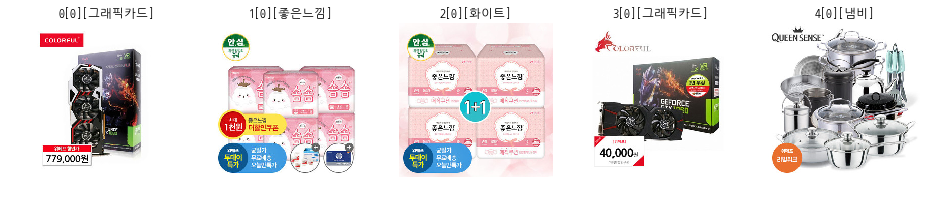

In [47]:
analyze_preds(out)

In [48]:
print(query)

뒷꿈치깔창,귀걸이,발받침대,캐논잉크,봄에입기좋은,원더페이,지니킴,8500K,닌텐도스위치,다이슨선풍기,냉동게,xbox,닌텐도스위치파우치,빕스,여아한복,뷰코싯,XBOXONEX,다이슨슈퍼소닉,아동바지,로얄코펜하겐,생수,아동슬립온,봄에어울리는원피스,java,핸드폰거치대,나이키아동,뷰소닉,뷰소닉gsync,스타킹,조선의무국,제주도항공권,아동로퍼,ebook,구두,스탠드,tensorflow,ㅔㄴ4,다이슨드라이어,칠리크랩,14K귀걸이,8500K\,ps4프로,머리방울,쉐도우,맥북,라이드,한복,가방,백팩,헤어드라이,고데기,디지털데이,생리대,다이슨,뷰코셋2,간장게장,인공눈물,아동스키복,자전거,티팟,바퀴의자,꼬막,뒷꿈치패드,세타필어드밴스울트라로션,써피스,안구건조증,x76a,랑콤리프팅,드라이,도장,겨자,뷰코세,제주도,가죽백팩,e560잉크,조끼,좋은느낌,리빙위크,스위치젤다,라면,어린이칫솔,전복,UHD모니터,안약,교사슬리퍼,머리끈,gaync,쉐도우팔레트,식염수,아동내복바지,유아한복,서랍장,네스프레소,여아슬립온,플스4,발받침,남성로션,미세모칫솔,세라구두,사과,1060,e560,4K모니터,4K모니터42,2462996,매직시트,고추장,나트라케어,디지털데아,양파,스위치,도서,ps4,뷰코셋,곤지암스파,전동바이크,혁띠,매니큐어,슈즈코치,배즙,아기한복,텐서플로,홈드레스,랑콤레네르지,와사비망고,리바이스청바지,와사비망고모니터,웨지우드,카프리썬,xboxonex,와사비망고재은이,안나수이스타킹,웨스트우드,비비안팬티,4K42,하이브리드자전거,gsync,4K모니터42형,다이슨드라이,현미경,무드등,나이키프리모,세컨스킨,세타필,일반도서,트리트먼트,돌한복,다이슨드라이기,자바,칫솔,아이싱팩,플스4프로,와사비망고43,곤지암스키강습,랑콤,X716A,나이키,1080,맥북프로,셔츠,텐서플로우,레페토,리바이스하의,헤어왁스


In [50]:
out

[(18.161806,
  3521487,
  '[컬러풀] GTX1080 8GB 그래픽카드',
  '그래픽카드,컬러풀,그카,1080,6GB,GTX1080VULCANU,1080,'),
 (16.79044,
  3510053,
  '[투데이특가] 좋은느낌 생리대 3+3팩',
  '좋은느낌,솜솜,순면생리대,생리대,순면,좋은느낌생리대,좋은순면,화이트,애니데이,입는오버나이트'),
 (16.79044,
  3500355,
  '[투데이특가] 좋은느낌 생리대 38+38',
  '좋은느낌,화이트,순수,클린,생리대,중형생리대,대형생리대,팬티라이너,오버나이트,좋은순면'),
 (14.705926,
  3511172,
  '[컬러풀] GTX1060 6GB 그래픽카드',
  '그래픽카드,컬러풀,그카,1060,6GB,GTX1060VULCANU,'),
 (12.98283,
  3514159,
  '[리빙위크] 퀸센스 빠야팬 24cm 외 ',
  '냄비,주전자,냄비세트,팬,후라이팬,차주전자,차망주전자,찜기,,리빙위크'),
 (12.256606,
  3503208,
  '[리빙위크] 블룸엣홈 식기&주방용품',
  '블룸엣홈,주방용품,실리콘,공기,도마,대접,조리도구,식기,커트러리,리빙위크'),
 (12.256606,
  3509649,
  '[리빙위크] 리빙숲 리빙박스72L 4개',
  '리빙박스,이불정리함,장난감정리함,플라스틱리빙박스,옷정리함,틈새선반,수납선반,리빙숲,접시꽂이,리빙위크'),
 (12.256606,
  3518099,
  '[리빙위크] 리베 북유럽풍5단 서랍장',
  '미니서랍장,3단서랍장,2단서랍장,4단서랍장,플라스틱서랍장,예쁜서랍장,옷서랍장,수납장,거실서랍장,리빙위크'),
 (12.256606,
  3520946,
  '[리빙위크] 글라스락 밀폐용기 142종',
  '글라스락,밀폐용기,반찬통,글라스락이유식용기,글라스락세트,유리병,유리용기,전자렌지용기,글라스락핸디,리빙위크'),
 (12.256606,
  3520992,
  '[리빙위크] 코즈니 주방 데코 375종',
  '

In [49]:
list(map(lambda x: (x[0], x[2]), out))

[(18.161806, '[컬러풀] GTX1080 8GB 그래픽카드'),
 (16.79044, '[투데이특가] 좋은느낌 생리대 3+3팩'),
 (16.79044, '[투데이특가] 좋은느낌 생리대 38+38'),
 (14.705926, '[컬러풀] GTX1060 6GB 그래픽카드'),
 (12.98283, '[리빙위크] 퀸센스 빠야팬 24cm 외 '),
 (12.256606, '[리빙위크] 블룸엣홈 식기&주방용품'),
 (12.256606, '[리빙위크] 리빙숲 리빙박스72L 4개'),
 (12.256606, '[리빙위크] 리베 북유럽풍5단 서랍장'),
 (12.256606, '[리빙위크] 글라스락 밀폐용기 142종'),
 (12.256606, '[리빙위크] 코즈니 주방 데코 375종'),
 (12.235758, '[리빙위크] 위즈홈 옷정리트레이 54P'),
 (12.235758, '[리빙위크] 3M 정전기청소포/물걸레'),
 (12.228773, '[리빙위크] 프렌치불 식기 리퍼대전'),
 (11.153339, '네스카페 돌체구스토 정품 캡슐 커피'),
 (11.119246, '다이슨 V10 앱솔루트 플러스 청소기'),
 (11.069601, '[무료배송] 웨스트우드 역대급 98종!'),
 (10.978725, '[플레이특가] 제주도 편도 항공권'),
 (10.97827, '[투데이특가] EUP VH806 무선청소기'),
 (10.568727, '[당일발송] 간장게장 + 양념게장SET'),
 (10.568727, '[무료배송] 입맛살리는 명란파치 1kg'),
 (9.384893, '[투데이특가] 맑음 배도라지 50팩'),
 (8.776255, '[엄마니까] 봄땡처리선착순+20%쿠폰'),
 (8.60473, '[무료배송] 풀무원샘물 생수 2Lx12外'),
 (8.4866905, '[무료배송] 가디건/니트/베스트'),
 (8.194525, '[쿠폰할인] 군기저귀&엘리스 종합전'),
 (8.146889, '[무료배송] 릴리안 생리대+골라담기'),
 (8.146889

### 구매 did로 부터 랭킹 테스트 (1)

- 구매 did 들의 dc를 가져옴
- dc 를 쿼리문으로 바꿔서 검색

In [23]:
dids = mg_get_ordered_dids(1000007, limit=64)

In [24]:
res = es_scan_dc_by_dids(list(dids))

In [25]:
def make_query_from_dcs(es_result):
    out = set()
    for hit in es_result['hits']['hits']:
        _source = hit['_source']
        out.add(_source['dc'].replace(" ",""))
    return ",".join(out)

In [26]:
query = make_query_from_dcs(res)

In [28]:
query

'ZUN-SO,ZUN-SO-HDH,거치대,차량,차량용,차량용거치대,스마트폰거치대,휴대폰거치대,핸드폰거치대,차량편의용품,송풍구거치대,CD슬롯거치대,에어컨거치대,자동차거치대,차량거치대,통풍구거치대,슈즈코치,운동화세일,운동화특가,운동화,신발,아동운동화,키즈운동화,아동화,아기신발,아기운동화,나이키,nike,신발,나이키운동화,나이키키즈,나이키아동화,나이키아동운동화,나이키키즈운동화,나이키신발,나이키아동신발,나이키키즈신발,나이키다이나모프리,나이키다이나모키즈,나이키아동신발,나이키이가신발,신생아신발,다이나모프리,나이키다이나모프리PS,다이나모,나이키다이나모,나이키테아키즈,나이키테아토들러,나이키키즈테아,나이키유아운동화,나이키아기신발,키즈신발,나이키에어포스키즈,나이키키즈에어포스,나이키포스키즈,나이키포스1키즈,타이니90,나이키타이니90,나이키맥스타이니90,나이키맥스타이니키즈,,슈즈코치,운동화특가,운동화세일,운동화,신발,런닝화,나이키,나이키에어맥스,나이키맥스,나이키에어맥스95,나이키에어맥스97,나이키업템포,업템포,에어모어업템포,에어멕스,나이키맥스신발,나이키에어맥스신발,나이키에어맥스운동화,신발신상품,운동화신상품,나이키에어맥스,에어맥스97울트라17프리미엄,에어맥스95LXW건스모크,에어맥스97옵시디언,에어맥스1애니버서리,에어맥스95OG,나이키에어맥스95형광,맥스95형광,에어맥스97ULW화이트,에어모어업템포트리플블랙,,세타필,세터필,대용량,크림,플러스,PLUS,+,무료배송,cetaphil,모이스처라이징,모이스쳐라이징,세타필대용량,세타필크림,세타필클렌져,세타필로션크림,세타필보습,보습로션,유아로션,세타필로션,세타필크림,모니터,아수스모니터,에이수스모니터,ASUS모니터,게이밍모니터,지싱크모니터,커브드모니터,144Hz모니터,게임모니터,27인치게이밍모니터,월튼,월튼키즈,겨울신상,가을점퍼,패딩,아동복,아동가을,애기옷,아동상하복,아동점퍼,칫솔,미세모칫솔,마시마로칫솔,캡슐커피,호환캡슐,네스프레소호환캡슐,네스프레소캡슐,네쏘호환캡슐,에스프레소,에스프레소캡슐,캡슐,호환,네쏘,커피,원두커피,원두,아메리카노,무배,무

In [29]:
result = es_search_by_dc(query, wepick_dids)
print(result['hits']['total'])

97


In [30]:
out = refine_ranked_result(result)

: 91.66343/아동공용의류,89.763336/아동공용의류,43.402073/런닝화/운동화 기타,39.398117/캡슐커피/티백커피,37.61205/유아동신발


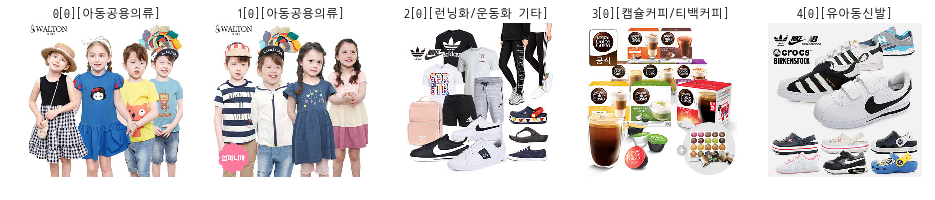

In [31]:
analyze_preds(out)

In [32]:
list(map(lambda x: (x[0], x[2]), out))

[(91.66343, '[어린이날] 월튼 나들이 룩 '),
 (89.763336, '[엄마니까] 월튼 여름 특가 대잔치'),
 (43.402073, '[무료배송] 빅브랜드 역대급 295종'),
 (39.398117, '네스카페 돌체구스토 정품 캡슐 커피'),
 (37.61205, '[어린이날] 인기 브랜드슈즈 파격가!'),
 (36.73542, '[무료배송] 뉴발란스/아디다스外'),
 (32.321087, '[투데이특가] 마미포코 360핏 4팩'),
 (32.217937, '[어린이날] 아디다스外 아동 20%쿠폰'),
 (31.641966, '[어린이날] 나이키X크록스 가격인하!'),
 (31.29245, '[투데이특가] 김우빈 마스크팩 100장'),
 (31.23408, '[원더쿠폰] 봄신상 여성구두 20%쿠폰'),
 (30.368885, '[투데이특가] 좋은느낌 생리대 38+38'),
 (29.37479, '[주간특가] 캐릭터 아동 실내복 모음'),
 (27.237707, '[투데이특가] 몽땅키즈 봄 아동복'),
 (27.125755, '[투데이특가] 더사랑이 여름 아동복'),
 (24.633902, '[투데이특가] 좋은느낌 생리대 3+3팩'),
 (24.539629, '[무료배송] 풀무원샘물 생수 2Lx12外'),
 (23.33269, '[무료배송] 릴리안 생리대+골라담기'),
 (23.33269, '[투데이특가] 시크릿데이 생리대 4팩'),
 (23.043438, '[롯데] 르까프 아동/성인 빅세일'),
 (22.809448, '[하객패션] 신상 로퍼/구두+원더쿠폰'),
 (22.273052, '[투데이특가] 노파머스 대용량 샴푸'),
 (21.67415, '[원더쿠폰] 봄 귀걸이,추가할인쿠폰'),
 (20.664837, '[무료배송] AHC BEST 스킨케어 30종'),
 (20.617329, '[투데이특가] TV화제! 깔라만시 젤리'),
 (18.502413, '[투데이특가] 플레이도 초특가 할인 '),
 (17.231045, '[원더쿠폰] 미쟝센 

### 구매 did로 부터 랭킹 테스트 (2)

- 구매 did 들의 ti2,... 또는 tn2,... 을 가져옴
- 이들의 빈도를 이용하여 검색

In [35]:
dids = mg_get_ordered_dids(1000007, limit=64)
tn2s = es_scan_field_by_dids(list(dids), 'tn2')

In [36]:
def collect_field_from_es_result(es_result, field):
    out = []
    for hit in es_result['hits']['hits']:
        data = hit['_source'][field]
        out.append(data)
    return out

In [37]:
tn2s = collect_field_from_es_result(tn2s, 'tn2')

In [38]:
','.join(tn2s)

'생리대,여성화,국내,칫솔/면도/비누,모니터/프린터,유아동의류,런닝화/운동화,생활/이미용가전,유아동신발/잡화,선물세트,지갑/벨트,유아동의류,남성화,커피,내외장용품,스킨케어,기초화장품,헤어케어,생수/음료,쥬얼리,남성화,모니터/프린터,헤어스타일링,계절가전,가정생활잡화,수산,생수/음료'

In [39]:
result = es_search_by_field('tn2', ','.join(tn2s), wepick_dids)
print(result['hits']['total'])

102


In [40]:
out = refine_ranked_result(result)

: 12.897254/잉크젯복합기-정품,11.094306/주스/과채음료,11.089098/생수/탄산수,9.864416/남성캐주얼화,9.296206/내의/잠옷/속옷


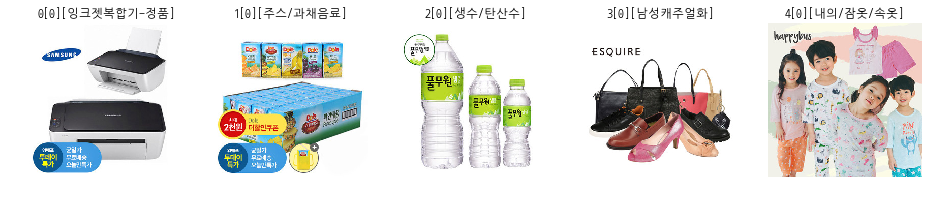

In [41]:
analyze_preds(out)

In [42]:
list(map(lambda x: (x[0], x[2]), out))

[(12.897254, '[투데이특가] 삼성J1660 컬러복합기'),
 (11.094306, '[투데이특가] Dole 주스 32팩 + 홀더'),
 (11.089098, '[무료배송] 풀무원샘물 생수 2Lx12外'),
 (9.864416, '[원더쿠폰] 에스콰이아 +20%쿠폰'),
 (9.296206, '[어린이날] 해피버스 7부/자가드내의'),
 (9.296206, '[모닝특가] S/S 베이비슈트 파격세일'),
 (9.296206, '[투데이특가] 몽땅키즈 봄 아동복'),
 (9.296206, '[무료배송] 캐릭터 봄 아동복 연합전'),
 (9.296206, '[엄마니까] 월튼 여름 특가 대잔치'),
 (9.296206, '[무료배송] 팬콧 트레이닝 최저세팅!'),
 (9.296206, '[무료배송] 미니로이 예쁨한도초과!'),
 (9.282148, '[엄마니까] 앤디애플 봄BYE 여름신상'),
 (9.282148, '[무료배송] S/S 브랜드 봄 아동복'),
 (9.282148, '[엄마니까] 쁘띠뮤 여름 횡재가격!'),
 (9.233565, '[무료배송] 봄 아동복 브랜드 연합전'),
 (9.233565, '[무료배송] 스탭키즈 봄 아동복 '),
 (9.233565, '[어린이날] 크록스키즈 단독 20%쿠폰'),
 (9.233565, '[어린이날] 월튼 나들이 룩 '),
 (9.231406, '[무료배송] 인디고키즈 S/S 아동복'),
 (9.231406, '[무료배송] 젤리스푼 봄/여름신상'),
 (9.231406, '[엄마니까] 디즈니 선착순놓치면후회'),
 (9.231406, '[무료배송] 예쁜아동복 하루만 ~25%'),
 (9.231406, '[엄마니까] 봄땡처리선착순+20%쿠폰'),
 (9.231406, '[무료배송] 신디키즈 봄 아동복'),
 (9.231406, '[무료배송] 와글/ 59~89 +25%쿠폰'),
 (9.231406, '[투데이특가] 더사랑이 여름 아동복'),
 (9.230571, '[무료배송] 쁘띠뮤 깜짝한정파격가'),
 (9.2

In [51]:
out

[(18.161806,
  3521487,
  '[컬러풀] GTX1080 8GB 그래픽카드',
  '그래픽카드,컬러풀,그카,1080,6GB,GTX1080VULCANU,1080,'),
 (16.79044,
  3510053,
  '[투데이특가] 좋은느낌 생리대 3+3팩',
  '좋은느낌,솜솜,순면생리대,생리대,순면,좋은느낌생리대,좋은순면,화이트,애니데이,입는오버나이트'),
 (16.79044,
  3500355,
  '[투데이특가] 좋은느낌 생리대 38+38',
  '좋은느낌,화이트,순수,클린,생리대,중형생리대,대형생리대,팬티라이너,오버나이트,좋은순면'),
 (14.705926,
  3511172,
  '[컬러풀] GTX1060 6GB 그래픽카드',
  '그래픽카드,컬러풀,그카,1060,6GB,GTX1060VULCANU,'),
 (12.98283,
  3514159,
  '[리빙위크] 퀸센스 빠야팬 24cm 외 ',
  '냄비,주전자,냄비세트,팬,후라이팬,차주전자,차망주전자,찜기,,리빙위크'),
 (12.256606,
  3503208,
  '[리빙위크] 블룸엣홈 식기&주방용품',
  '블룸엣홈,주방용품,실리콘,공기,도마,대접,조리도구,식기,커트러리,리빙위크'),
 (12.256606,
  3509649,
  '[리빙위크] 리빙숲 리빙박스72L 4개',
  '리빙박스,이불정리함,장난감정리함,플라스틱리빙박스,옷정리함,틈새선반,수납선반,리빙숲,접시꽂이,리빙위크'),
 (12.256606,
  3518099,
  '[리빙위크] 리베 북유럽풍5단 서랍장',
  '미니서랍장,3단서랍장,2단서랍장,4단서랍장,플라스틱서랍장,예쁜서랍장,옷서랍장,수납장,거실서랍장,리빙위크'),
 (12.256606,
  3520946,
  '[리빙위크] 글라스락 밀폐용기 142종',
  '글라스락,밀폐용기,반찬통,글라스락이유식용기,글라스락세트,유리병,유리용기,전자렌지용기,글라스락핸디,리빙위크'),
 (12.256606,
  3520992,
  '[리빙위크] 코즈니 주방 데코 375종',
  '